In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [10]:
# Using the inspector to print the column names within the 'station' table and its types
station_columns = inspector.get_columns('station')
for column in station_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Using the inspector to print the column names within the 'measurement' table and its types
measurement_columns = inspector.get_columns('measurement')
for column in measurement_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
# Querying Measurement table for max date and using scalar to grab first row/column instance
max_date = session.query(func.max(Measurement.date)).scalar()

max_date

'2017-08-23'

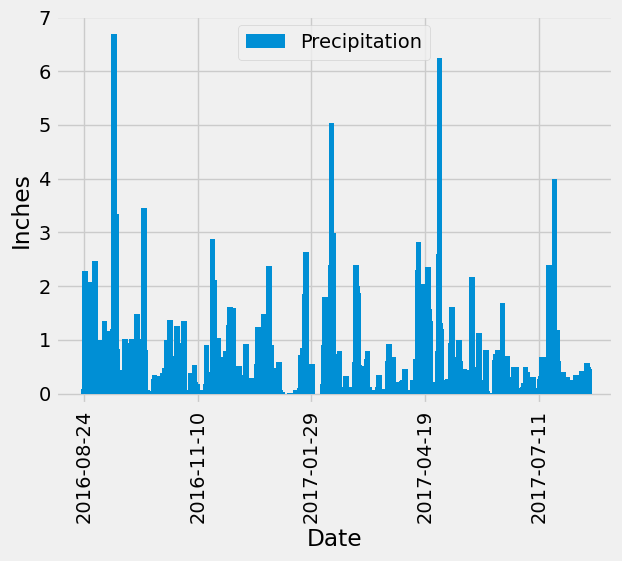

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
year_ago = dt.datetime.strptime(max_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
past_year_info = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
past_year_df = pd.DataFrame(past_year_info, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
past_year_df = past_year_df.sort_values(by='Date', ascending=True)
past_year_df = past_year_df.set_index('Date')

# Use Pandas Plotting with Matplotlib to plot the data
rain_chart = past_year_df.plot(kind='bar', capstyle="round", width=25)  # Setting bar width and capstyle
rain_chart.xaxis.set_major_locator(plt.MaxNLocator(5))  # Display only 5 tick labels
plt.xlim(-125, 2325)
plt.ylim(-.2)
plt.ylabel('Inches')
plt.show()


In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
past_year_stats = past_year_df.describe()
past_year_stats

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Station.station).distinct().count()
station_count


9

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_list = session.query(Measurement.station, func.count(Measurement.station).label("staion_count")).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc())

for station, station_count in station_list:
    print(station, station_count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Extracting the most active station from the list created above
most_active_station = station_list[0][0]

# Querying Measurements table for most active station
most_active_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station)
    
for stats in most_active_stats:
    print(f"Lowest: {stats[0]} Highest: {stats[1]} Average: {round(stats[2], 2)}")
    

Lowest: 54.0 Highest: 85.0 Average: 71.66


In [18]:
# Finding the max date for the most active station and date 12 months prior
most_active_max_date = session.query(func.max(Measurement.date)).\
    filter(Measurement.station == most_active_station).scalar()

most_active_year_ago = dt.datetime.strptime(most_active_max_date, '%Y-%m-%d') - dt.timedelta(days=365)    

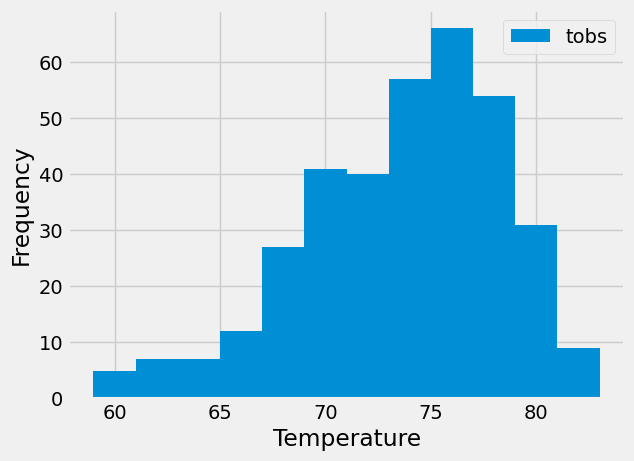

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_past_year = session.query(Measurement.tobs).\
    filter(Measurement.date >= most_active_year_ago).\
    filter(Measurement.station == most_active_station)

# Putting query results into DataFrame 
hist_data = pd.DataFrame(most_active_past_year)

# Plotting histogram, adjusting ticks on y-axis, count of bins
hist_chart = hist_data.plot(kind='hist', yticks=range(0, 70, 10), bins=12)
# Adding label for x axis
hist_chart.set_xlabel("Temperature")

plt.show()



# Close Session

In [20]:
# Close Session
session.close()